<a href="https://colab.research.google.com/github/alouwyck/maxsypy/blob/main/seminaries/UM6P_jan_2025/Day2/Part_2_Introduction_to_Machine_Learning_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

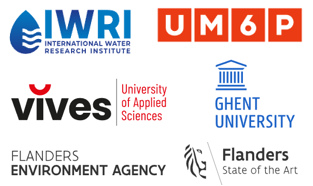<br>


**Mathematical Models and Artificial Intelligence**<br>
**for Solving Groundwater Flow Problems**<br>
Workshop organized by the<br>
International Water Research Institute (IWRI)<br>
University Mohammed VI Polytechnic<br>
January 6-7, 2025<br>
Dr. Andy Louwyck

---



<font size="6"><strong>DAY 2 - Artificial Intelligence</strong></font>

---
---

# **Part 2 - Introduction to Machine Learning with Python**

This notebook is a brief introduction to solving machine learning problems with Python. In particular, some examples of supervised learning are discussed:

- classification with K nearest neighbors
- classification with logistic regression
- classification with a decision tree
- simple linear regression
- polynomial regression


**Supervised learning** uses labeled data to predict outcomes, while **unsupervised learning** discovers hidden patterns in unlabeled data without human intervention. As an example of the latter, the k-means clustering algorithm will be demonstrated.

## **0. Import Statements**

We need the following libraries:
- [NumPy](https://numpy.org/): library for numerical computation.
- [Pandas](https://pandas.pydata.org/): library for analyzing structured data
- [Matplotlib](https://matplotlib.org/): library for visualizing data
- [Scikit-Learn](https://scikit-learn.org/stable/): machine learning library

We import these libraries using the `import` command. It is customary to give NumPy alias `np` and Pandas alias `pd`. From Matplotlib, we need the `pyplot` module; the convention is to import it as `plt`. From Scikit-Learn, we import only the classes we use at the time we need them.

In [1]:
import numpy as np  # numeric python
import pandas as pd  # python data analysis library
import matplotlib.pyplot as plt  # python library for visualizations

We also clone the [MAxSyPy](https://github.com/alouwyck/maxsypy) package from GitHub for simulating axisymmetric groundwater flow:

In [2]:
import os, shutil

# remove directory 'maxsypy' first if it already exists
path = "maxsypy"
if os.path.exists(path):
    shutil.rmtree(path)

# clone maxsypy repository from Github
!git clone https://github.com/alouwyck/maxsypy


# put maxsypy package directory in the current working directory
os.rename(path, 'temp')
shutil.copytree(os.path.join('temp', path), path);
shutil.rmtree('temp')

Cloning into 'maxsypy'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 372 (delta 56), reused 5 (delta 5), pack-reused 233 (from 2)
Receiving objects: 100% (372/372), 22.62 MiB | 26.29 MiB/s, done.
Resolving deltas: 100% (163/163), done.


The MAxSyPy package implements several analytical and semi-analytical solutions discussed in my PhD thesis (Louwyck, 2023). We will use it to generate datasets.

## **1. What is Machine Learning?**

Let's first try to understand the difference between traditional programming and classical AI on one hand and machine learning on the other. The following picture clearly summarizes it:

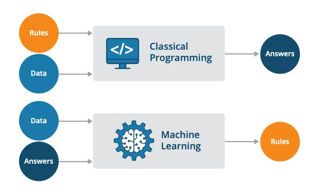

In both cases we have input data. In classical programming and AI, we also know the rules, which is called the **model**. When an **algorithm** applies these rules to the input data, then we get the answers or the output. In machine learning, we don't know the rules. In case of **supervised learning**, however, we know the answers, and the machine learning algorithm will derive the rules from these (input, output) pairs. So, a machine learning algorithm returns a model! That model can be used afterwards like a classical program to **predict** answers on new data. Note that **unsupervised learning** algorithms only get the data as input and not the answers, but they also train a model that can be used to make predictions.

### Classical Programming

An example to illustrate this. Suppose we have to write a program that determines whether the drawdown observed during a pumping test is transient or steady by applying the following statement: "When the drawdown is observed within 10 days of starting the test, it is considered transient; otherwise, the drawdown is steady." That is very straightforward to implement:

In [3]:
threshold = 10
time = float(input("How many days after starting the pumping test is the drawdown observed?\n"))  # data (4 days)
drawdown = 'transient' if time < threshold else 'steady'  # rule
print(f'The drawdown is {drawdown}!')                     # answer

How many days after starting the pumping test is the drawdown observed?
4
The drawdown is transient!


That is a very simple example of traditional programming:
- you get the input data: the time after starting the pumping test;
- and the rule: if the given time is lower than 10 days, then the drawdown is transient, otherwise it is steady;
- so the algorithm is able to calculate the output by applying the rule to the input.

### Machine Learning

In Machine Learning, we do not know the rule, but we get the input and the ouput. To illustrate how this works, we first generate a dataset in the traditional way using function `hantush_jacob`. Remember that this solution simulates transient flow to a pumping well fully penetrating a leaky aquifer. However, the flow to the pumping well becomes steady when the well discharge is balanced by the change in leakage. In this particular example, the simulated drawdown is labeled as transient if it is less than 2 m; otherwise, it is labeled as steady:

In [4]:
from maxsypy.special import hantush_jacob

r_obs = 1  # radial distance (m) from the pumping well where the observations are made
t_obs = np.logspace(-4, 5, 100)  # observation times (d)

T = 500   # aquifer transmissivity (m²/d)
S = 0.01  # aquifer storativity (-)
c = 750   # resistance (d) of the bounding aquitard
Q = 1000  # pumping rate (m³/d)

s_obs = hantush_jacob(t=t_obs, r=r_obs, Q=Q, T=T, S=S, c_top=c).squeeze()  # observed drawdown (m)
is_steady = s_obs >= 2  # observed drawdown is steady if it is not less than 2 m

We put the obervation times `t_obs` and the corresponding labels `is_steady` in a Pandas `DataFrame`:

In [5]:
table = pd.DataFrame(dict(time=t_obs, steady=is_steady))
table.head()

,time,steady
0,0.000100,False
1,0.000123,False
2,0.000152,False
3,0.000187,False
4,0.000231,False


Suppose now that this is the dataset we've observed, and we don't know how the data were generated. So, here the challenge is to derive the rule from these (input, output) pairs. Taking a closer look to the table, we see there are two columns: one with the observed time after starting the pump and one indicating the corresponding state of the drawdown. So the input is the 'time' column and the output is the 'steady' column. In machine learning, the first is called a **feature**, and the second contains the **labels**.

It's always a good idea to visualize the data. Let's define a function to do that:

In [6]:
def plot_table(table):
    '''
    table: Pandas DataFrame with columns 'time' and 'steady'
    returns: axes
    '''
    _, ax = plt.subplots(1, 1, figsize=(8, 2))
    transient = ~table.steady
    plt.semilogx(table[table.steady].time, np.ones(table.steady.sum()), 'g.');
    plt.semilogx(table[transient].time, np.zeros(transient.sum()), 'r.');
    plt.xlabel('observed time (d)');
    plt.ylabel('is steady');
    plt.yticks((0, 1));
    ax.set_yticklabels(('no', 'yes'))
    plt.grid();
    return ax

By plotting the data we see it is easy to separate the 'transient' and 'steady' times:

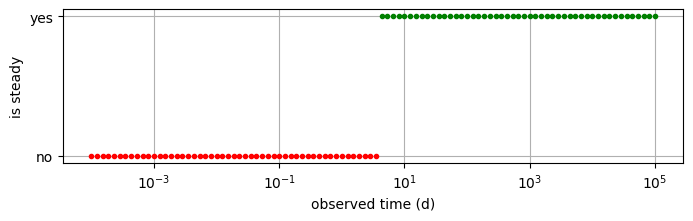

In [7]:
plot_table(table);

### Naive Algorithm

A naive way of separating both classes is defining the threshold as the average of the maximum 'transient' time and the minimum 'steady' time:

In [8]:
max_transient = table[~table.steady]['time'].max()  # max transient time
min_steady = table[table.steady]['time'].min()      # min steady time
threshold = (max_transient + min_steady) / 2        # mean of max transient time and min steady time
print(f'maximum time when drawdown is transient: {max_transient} d')
print(f'minimum time when drawdown is steady: {min_steady} d')
print(f'threshold is {threshold} d')

maximum time when drawdown is transient: 3.5111917342151346 d
minimum time when drawdown is steady: 4.328761281083062 d
threshold is 3.919976507649098 d


Let's add the derived threshold to the plot:

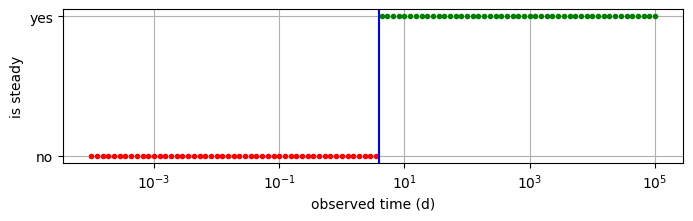

In [9]:
ax = plot_table(table);
yl = ax.get_ylim();
ax.plot(threshold * np.ones(2), [-1, 2], 'b-');
ax.set_ylim(yl);

Using this new threshold, we can run the program again:

In [10]:
time = float(input("How many days after starting the pumping test is the drawdown observed?\n"))  # data (4 days)
drawdown = 'transient' if time < threshold else 'steady'  # rule
print(f'The drawdown is {drawdown}!')                     # answer

How many days after starting the pumping test is the drawdown observed?
4
The drawdown is steady!


We call this algorithm 'naive', but actually, determining a threshold value as we have done here is how the **decision tree** algorithm does it. And the **logistic regression** algorithm also determines a threshold, as we will see below.

### Nearest Neighbor

Another way to decide whether the drawdown is transient or steady given a new time, is to simply adopt the output of the closest observation time, called the **nearest neighbor**, which is found by calculating the absolute difference between the given time and the observation times in the dataset and taking the sample having the smallest absolute difference:

> $\min_i{|t_{new} - t_{obs, i}|}$

where $t_{new}$ is the given time and $t_{obs,i}$ is the $i$-th observation time in the dataset. This nearest neighbor is easily found using Pandas methods `abs()` and `argmin()`:

In [11]:
time = float(input("How many days after starting the pumping test is the drawdown observed?\n"))  # input time (2 days)
abs_difference = (time - table.time).abs()  # absolute difference
steady = table.steady.iloc[abs_difference.argmin()]  # label of nearest neighbor
print(f"The drawdown is {'steady' if steady else 'transient'}!")  # answer

How many days after starting the pumping test is the drawdown observed?
2
The drawdown is transient!


When we visualize the new data point given by the user, then we see the closest point from the dataset has label 'steady' indeed:

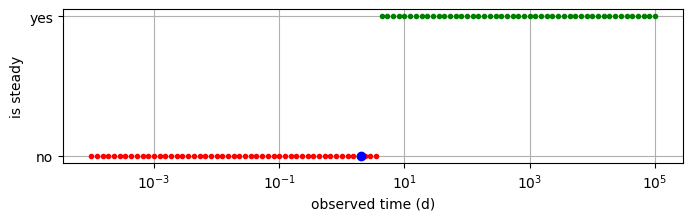

In [12]:
ax = plot_table(table);
ax.plot(time, steady, 'bo');  # add new data point

This is an example of a very simple machine learning model. Actually, it is a special case of a very well-known machine learning algorithm, called **K Nearest Neighbors** (KNN). As the name suggests, this generalized version selects the K nearest neighbors to determine the output of a new sample. Here, we've set K to 1.

## **2. Classification**

Classification is a type of **supervised learning** used to **predict qualitative variables**, also called categorical variables, by learning a function that maps input features to output **labels**.

In our dataset, the labels are stored in the `'steady'` column. As there are two labels only, `True` and `False`, it is a **binary classification** problem.

### K Nearest Neighbors

As already mentioned, we can apply the K Nearest Neighbors (KNN) algorithm to determine whether drawdown is steady or not. Using class `KNeighborsClassifier` from Scikit-Learn, it is very straightforward to apply this algorithm:

In [13]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)  # instantiate with K = 3
model.fit(table[['time']].values, table['steady'])  # fit data

new_time = 4
model.predict([[new_time]]).item()  # predict label for new observation time

False

We first instantiate the class and the resulting object is assigned to variable `model`. Then we fit the data, where the first argument passed to method `fit` are the features, in this case the `'time'` values, and the second argument are the labels, in this case column `'steady'`. Finally, a prediction is made for a new time value by calling method `predict`. Note the use of double brackets as these methods only accept 2D matrices or tables as input for the features!

Let's plot the new data point (4 days) and its predicted label (`False`):

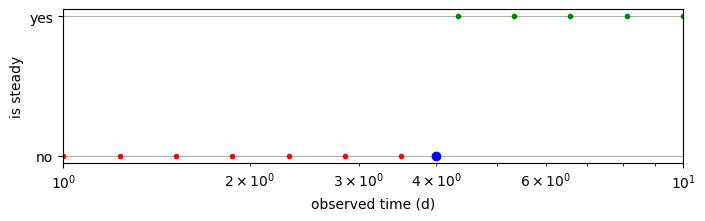

In [14]:
ax = plot_table(table);
ax.set_xlim((1, 10))
ax.plot(new_time, False, 'bo');

Two of the closest data points have label `False` and only one has label `True`; hence, a given observation time of 4 days is assigned label `False` indeed. However, if we would look at the nearest neighbor only (K=1), then the predicted label would be `True`, as is shown with following the code block:

In [15]:
# prompt: give me the three points in table that are closest to time == 4

table['time_diff'] = np.abs(table['time'] - new_time)
closest_points = table.nsmallest(3, 'time_diff')
print(closest_points[['time', 'steady', 'time_diff']])
table = table.drop('time_diff', axis=1)

        time  steady  time_diff
51  4.328761    True   0.328761
50  3.511192   False   0.488808
49  2.848036   False   1.151964


It's important to realize the machine learning model sometimes predicts wrong values! Therefore, it is imperative to always evaluate a machine learning model to assess its performance. Here, we may calculate the **accuracy**, which is the number of correct predictions divided by the total number of samples:

In [16]:
model.score(table[['time']].values, table['steady'])  # returns accuracy

1.0

We get a score of 100%, which means the model predicts the correct label for all samples in the training set. However, when we work with real datasets, it is almost impossible to achieve 100% accuracy because most datasets contain errors and outliers.

### Logistic Regression

In our first naive approach to solve the drawdown problem, we derived a threshold from the maximum 'transient' time and the minimum 'steady' time. By doing so, we only used two data points. A more robust algorithm would use all data points to determine the threshold instead of only two. An example of such an algorithm is **logistic regression**.

It's common practice to assign the features to variable `X` and the target to variable `y`. Because some of the `'time'` values are very large, it is also a good idea to normalize this variable, which we'll do here by taking the logarithm:

In [17]:
X = np.log10(table[['time']].values)  # normalized feature
y = table.steady.values               # labels

Note that we assign the NumPy arrays by getting `DataFrame` attribute `values`.

Again, the `LogisticRegression` class from Scikit-Learn is instantiated, after which method `fit` is invoked to train the model. The threshold is calculated using the model **parameters**. Finally, the `predict` method is called to get the label for the new temperature value.

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty=None)  # instantiate
model.fit(X, y)  # fit data

threshold = -model.intercept_.item() / model.coef_.item()  # determine threshold
print(f'threshold is {10**threshold} d')  # don't forget X is log-transformed!

model.predict([[new_time]]).item()  # predict label for a new time equal to 4 days

threshold is 3.8995759804262233 d


True

Again, the accuracy is 100% for this model:

In [19]:
model.score(X, y)  # accuracy

1.0

The model applies a linear transformation to the input feature, in this case $\log(t)$:

> $f = a\log(t) + b$

Parameters $a$ and $b$ are optimized by the algorithm by minimizing an error function or **loss function**, which quantifies the difference between true and predicted labels. This optimization is the actual **training** of the model. Note that the threshold equals $-b/a$.

The transformed variable $f$ is finally converted to a number between 0 and 1 by applying the **sigmoid** function $\sigma$:

> $p = \sigma(f) = \frac{1}{1+\exp(-f)}$

Variable $p$ may be interpreted as the probability the label is equal to 1, or in this example, the probability that the drawdown is steady. The label is thus found by applying the `round` function to this probability value: if $p >= 0.5$, then the drawdown is steady, otherwise it is transient.

Let's visualize the derived threshold and the corresponding sigmoid function, which shows us the probability that the flow to the well is steady for a given observation time:

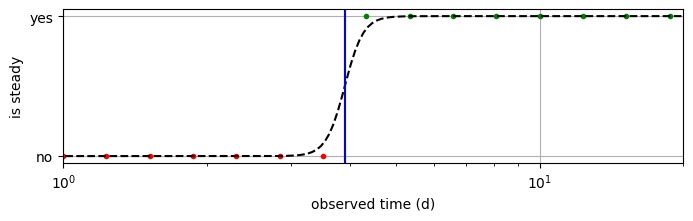

In [20]:
ax = plot_table(table);
sigmoid = lambda f: 1 / (1 + np.exp(-f))
f = lambda x: model.coef_.item() * x + model.intercept_.item()
x = np.linspace(-4, 5, 1000)
yl = ax.get_ylim()
ax.plot(10**x, sigmoid(f(x)), 'k--');
ax.plot(10**threshold*np.ones(2), [-1, 2], 'b-');
ax.set_xlim((1, 20));
ax.set_ylim(yl);

We see the logistic regression model separates both classes of data points perfectly indeed!

### Decision Tree

Another popular machine learning model that we've already mentioned is a decision tree. Scikit-Learn has a `DecisionTreeClassifier` class to train a decision tree for classification tasks. Let's try it out on our dataset:

In [21]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

model = DecisionTreeClassifier()
model.fit(X, y)

DecisionTreeClassifier()

As the data points are perfectly separable, we get again a 100% accuracy score:

In [22]:
model.score(X, y)

1.0

Let's visualize the tree:

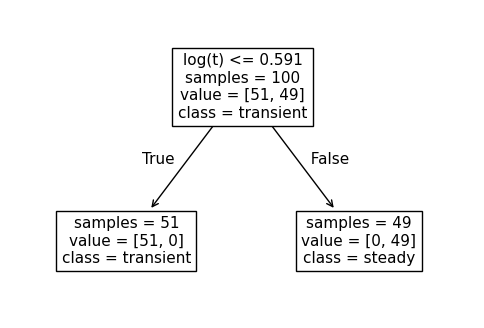

In [23]:
plt.figure(figsize=(6, 4))  # Adjust figure size
plot_tree(model,
          feature_names=['log(t)'],
          class_names=['transient', 'steady'],
          impurity=False,
          fontsize=11);

As expected, we get a tree with one level only, which is called a *decision stump*. How do we read this stump?

In [24]:
print(export_text(model, feature_names=['log(t)']))

|--- log(t) <= 0.59
|   |--- class: False
|--- log(t) >  0.59
|   |--- class: True



So, if `log(t)` is less than or equal to 0.59, then `steady` is `False`; otherwise, `steady` is `True`.

The decision tree applies a threshold of 0.59 to separate the observation times. Because the model is trained using the logarithm of these times, we need to transform this value back into the real time domain:

In [25]:
print(f'threshold is {10**model.tree_.threshold[0]} d')  # don't forget X is log-transformed!

threshold is 3.898603726870116 d


Actually, this threshold is calculated in the same way we did when applying our naive algorithm, as the average of the maximum 'transient' time and the minimum 'steady' time. The only difference is that the logartihm of the observation times is used here:

In [26]:
log_max_transient = np.log10(table[~table.steady]['time']).max()
log_min_steady = np.log10(table[table.steady]['time']).min()
threshold = (log_max_transient + log_min_steady) / 2
print(f'maximum log(t) when drawdown is transient: {log_max_transient:.2f}')
print(f'minimum log(t) when drawdown is steady: {log_min_steady:.2f}')
print(f'threshold is {threshold:.2f}')

maximum log(t) when drawdown is transient: 0.55
minimum log(t) when drawdown is steady: 0.64
threshold is 0.59


Finally, let's make some predictions:

In [27]:
new_times = np.log10([0.01, 0.1, 1, 10, 100, 1000])  # don't forget to log-transform!
model.predict(new_times.reshape(-1, 1))  # reshape to table with one column

array([False, False, False,  True,  True,  True])

### A more challenging example

The dataset we have used so far is very simple, as it contains a relatively small number of one-dimensional data points that are perfectly separable. In reality, machine learning algorithms for classification are applied to large n-dimensional datasets that are not perfectly separable. Let's create a similar dataset here, but this time we consider multiple distances to the pumping well and intentionally add some errors to the dataset, making the data points no longer linearly separable:

In [28]:
# observation distances and times
r_obs = np.logspace(-1, 2, 4)    # radial distance (m) from the pumping well where the observations are made
t_obs = np.logspace(-4, 5, 100)  # observation times (d)

# model parameters
T = 500   # aquifer transmissivity (m²/d)
S = 0.01  # aquifer storativity (-)
c = 750   # resistance (d) of the bounding aquitard
Q = 1000  # pumping rate (m³/d)

# simulate drawdowns
s_obs = hantush_jacob(t=t_obs, r=r_obs, Q=Q, T=T, S=S, c_top=c)  # observed drawdown (m)

# add random measurement error
np.random.seed(0)  # set random seed to ensure we get the same data each time we run the notebook
s_obs += np.random.randn(*s_obs.shape) * 0.01  # add error sampled from normal distribution
s_obs[s_obs<0] = 1e-5  # set negative drawdown values to 1e-5

# drawdown observations within 10 days are transient
t_steady = 10
steady = t_obs >= t_steady

# re-label 5% of the steady data points as transient
j = np.where((t_obs > 1) & (t_obs < 10))[0]
steady_full = np.tile(steady[np.newaxis, :], (4, 1))
n = 5
np.random.seed(25)
for i in range(4):
    jj = np.random.choice(j, n, replace=False)
    steady_full[i*np.ones(n, dtype=int), jj] = True

# create dataframe
t_obs_full = np.tile(t_obs[np.newaxis, :], (4, 1))
df = pd.DataFrame(dict(time=t_obs_full.flatten(),
                       drawdown=s_obs.flatten(),
                       steady=steady_full.flatten()))
df.head()

,time,drawdown,steady
0,0.000100,1.135573,False
1,0.000123,1.155233,False
2,0.000152,1.194322,False
3,0.000187,1.240248,False
4,0.000231,1.269821,False


Let's visualize the generated dataset:

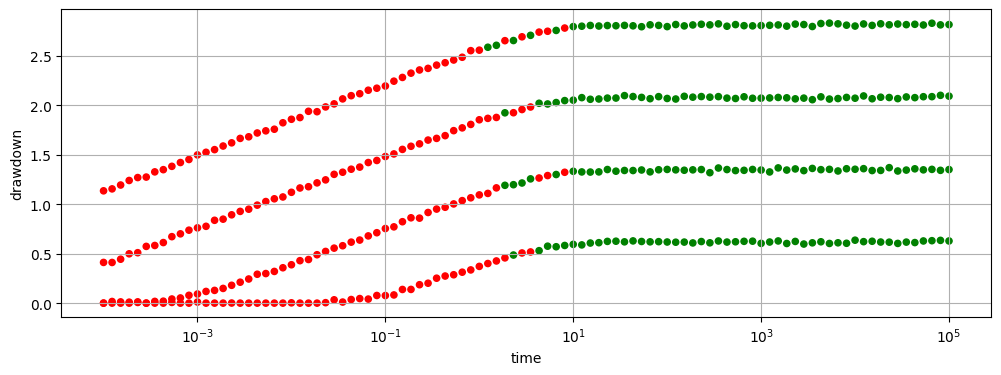

In [29]:
from matplotlib.colors import ListedColormap

def plot_data(df):
    cmap = ListedColormap(['red', 'green'])
    _, ax = plt.subplots(figsize=(12, 4))
    df.plot.scatter(x='time', y='drawdown', c=df.steady, cmap=cmap, logx=True, ax=ax, colorbar=False);
    ax.grid();
    return ax

plot_data(df);

Let's train the three models we've discussed earlier on this new dataset. First, we create `X` and `y` for the features and the labels:

In [30]:
X = df[['time', 'drawdown']].values  # features are 'time' and 'drawdown'
X[:, 0] = np.log10(X[:, 0])          # log-transform to normalize 'time'
y = df['steady'].values              # labels are stored in 'steady'

Applying logistic regression:

In [31]:
lr = LogisticRegression(penalty=None)
lr.fit(X, y)
lr.score(X, y)

0.96

Using KNN:

In [32]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)
knn.score(X, y)

0.975

Training a decision tree:

In [33]:
tree = DecisionTreeClassifier()
tree.fit(X, y)
tree.score(X, y)

1.0

The decision tree performs perfectly, while KNN does slightly better than logistic regression. Let's plot a confusion matrix for each of the models:

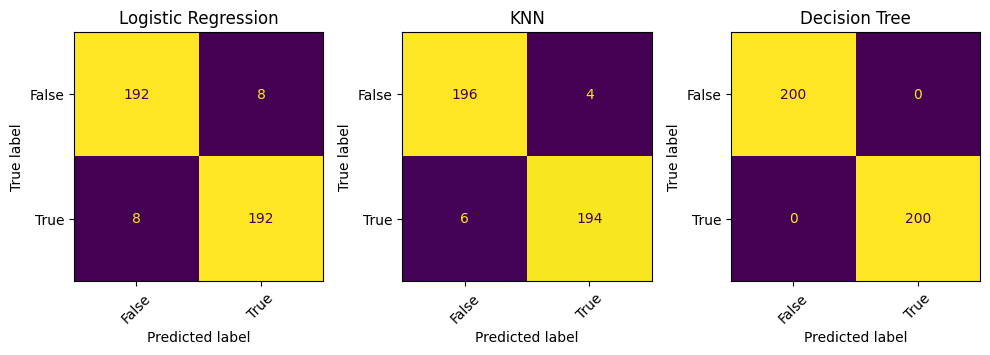

In [34]:
# prompt: plot for each model (lr, knn, tree) the confusion matrix in a row

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models =  [lr, knn, tree]
labels = ['Logistic Regression', 'KNN', 'Decision Tree']

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for ax, model, label in zip(axes, models, labels):
    cm = confusion_matrix(y, model.predict(X), labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
    ax.set_title(label)
plt.tight_layout()

A **confusion matrix** gives a better overview of the model's performance by displaying counts of true positives, true negatives, false positives, and false negatives based on predictions and actual labels:

- *True Positive* (TP): The model correctly predicts the positive class.
- *True Negative* (TN): The model correctly predicts the negative class.
- *False Positive* (FP): The model incorrectly predicts the positive class (also known as a Type I error).
- *False Negative* (FN): The model incorrectly predicts the negative class (also known as a Type II error).

Finally, let's predict the label for a drawdown of 1.4 m observed at 2 days after starting the pump using the three models:

In [35]:
t_new = 2
s_new = 1.4
X_new = [[np.log10(t_new), s_new]]

for model, label in zip(models, labels):
    print(label, ': ', model.predict(X_new).squeeze(), sep='')

Logistic Regression: False
KNN: True
Decision Tree: True


We plot the result to see why we get different predictions. The new data point is added to the plot (blue dot) and the separating line determined by the logistic regression algorithm:

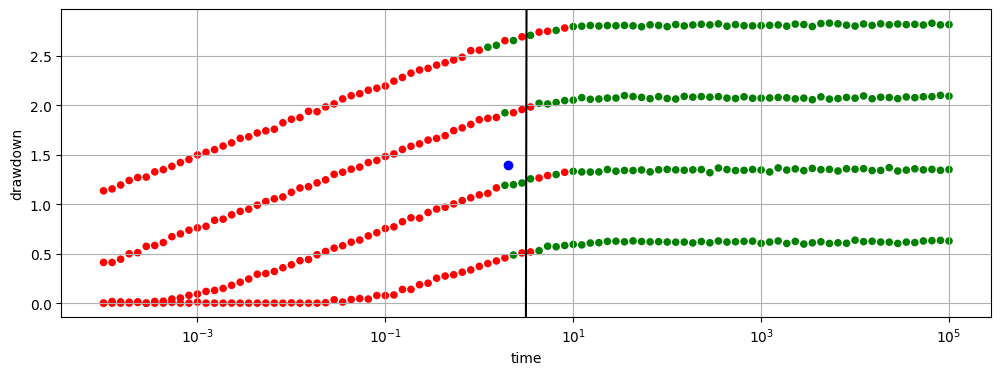

In [36]:
# Calculate the separating line using the logistic regression model's coefficients and intercept
log_t_obs_line = np.linspace(np.log10(t_obs[0]), np.log10(t_obs[-1]), 1000)
w, b = lr.coef_[0], lr.intercept_[0]
s_obs_line = -(log_t_obs_line * w[0] + b) / w[1]

# Plot the points from the training set, the separating line, and the new data point
ax = plot_data(df)
xl, yl = ax.get_xlim(), ax.get_ylim()
ax.semilogx(10**log_t_obs_line, s_obs_line, 'k-')  # Plot the separating line
ax.semilogx(t_new, s_new, 'bo');  # Plot the new data point
ax.set_xlim(xl);
ax.set_ylim(yl);

Because we have two features, the problem is two-dimensional, which is why the logistic regression algorithm determines a separating straight line in this example. If the problem were three-dimensional, it would find a separating plane, and in the case of higher-dimensional problems, it looks for a separating hyperplane. Thus, the logistic regression model is linear, whereas the other two models are nonlinear. The blue point clearly lies in the 'transient' part of the dataset as determined by the separating straight line. However, it is also closest to three 'steady' data points, which is why KNN predicts the new point as 'steady'. This also explains why KNN performs slightly better than the logistic regression model.

But what about the perfect performance of the decision tree? This is clearly an example of **overfitting**, as the model memorizes the data by creating as many nodes as necessary to achieve a perfect score. We can verify this by getting the depth of the tree, which is 11!

In [37]:
tree.get_depth()

11

One of the remedies to overcome overfitting is to define a limit on the depth of the tree. The `max_depth` of a decision tree is a hyperparameter that can be tuned using a validation set. What overfitting is and how it can be avoided by tuning hyperparameters is explained in a later section, but first, let's take a moment to discuss clustering.

## **3. Clustering**

Clustering is a fundamental technique in **unsupervised learning**, a type of machine learning where the algorithm is provided with data that has **no labels** or predefined categories. Unlike supervised learning, where the model learns from labeled data, unsupervised learning algorithms like clustering aim to find inherent patterns or groupings within the data. Clustering algorithms group similar data points together based on their features.

As an example, the previous dataset will be clustered using the well-known **k-means clustering** algorithm. The 'k' in the name indicates the number of clusters or groups the dataset is divided into, which the algorithm must know before training. In this case, we want two clusters:

In [38]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)  # k = n_clusters = 2 as we want two clusters
model.fit(X)  # unsupervised learning, so there is no y!!

KMeans(n_clusters=2)

Note that there are no labels `y` passed to the `fit` method because clustering is an unsupervised learning task, which requires an unlabeled training set.

Using the `predict` method, we get the cluster labels of the data points in `X`:

In [39]:
y_pred = model.predict(X)
np.unique(y_pred)  # cluster labels are 0 and 1

array([0, 1], dtype=int32)

Let's plot the result:

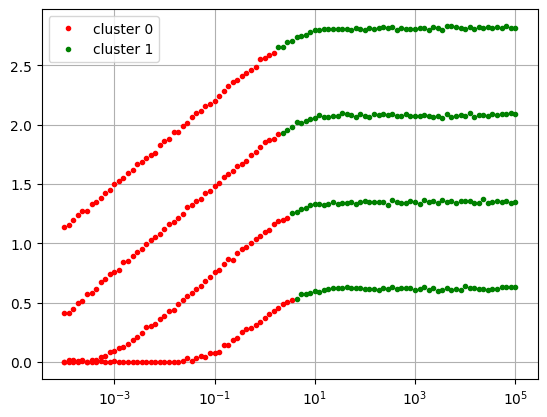

In [40]:
t = df['time'].values
s = df['drawdown'].values
plt.semilogx(t[y_pred==0], s[y_pred==0], 'r.', label='cluster 0');
plt.semilogx(t[y_pred==1], s[y_pred==1], 'g.', label='cluster 1');
plt.legend();
plt.grid();

It looks like the k-means clustering algorithm is able to distinguish the transient drawdowns from the steady drawdowns!

## **4. Regression**

Regression is also a type of **supervised learning**, but in this case, it is used to **predict quantitative variables**, such as house prices. The feature we want to predict is called the **target** or dependent variable; the other features are the independent variables.

### Simple Linear Regression

Let's start with simple linear regression, which involves predicting one dependent variable from one independent variable. Specifically, we will apply the **Cooper-Jacob method**, which matches a straight line to drawdown data plotted as a function of the logarithm of time since pumping began. This method is based on the Theis solution and is used to derive optimal values for aquifer transmissivity and storativity.

To illustrate how the method works, we first create a pumping test dataset using the `theis` function:

In [41]:
from maxsypy.special import theis

r_obs = 2  # radial distance (m) of observation well
t_obs = np.logspace(-4, 0, 50)  # observation times

T = 250   # aquifer transmissivity (m²/d)
S = 0.01  # aquifer storativity (-)
Q = 5000  # pumping rate (m³/d)

s_obs = theis(r=r_obs, t= t_obs, T=T, S=S, Q=Q).squeeze()  # drawdown (m)

np.random.seed(2025)  # set random seed
s_obs += np.random.randn(len(s_obs)) * 0.1  # add random measurement error (m)

Plotting the observed drawdowns:

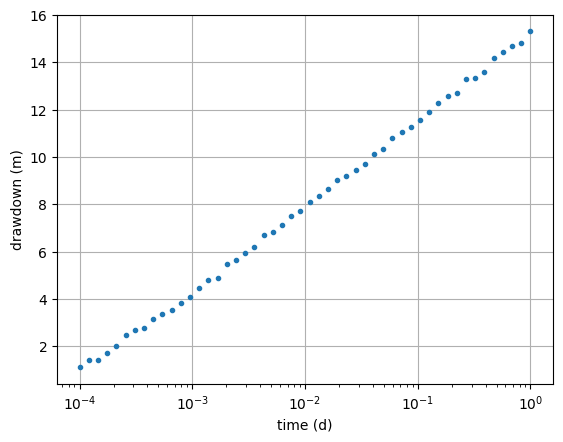

In [42]:
def plot_observations(t_obs, s_obs):
    plt.semilogx(t_obs, s_obs, '.');
    plt.grid();
    plt.xlabel('time (d)');
    plt.ylabel('drawdown (m)');

plot_observations(t_obs, s_obs)

Let's assume a **linear relation** between the logarithm of time, which we denote by $x$, and the drawdown, which we denote by $y$. Mathematically, this relation is expressed as follows:

> $y = ax + b$

where $a$ and $b$ are **parameters**. Note that this function expresses a straight line characterized by slope $a$ and intercept $b$. The parameters are derived by minimizing the squared differences between true marks $y$ and predicted marks $\hat{y}$:

> $L = \sum_{i=1}^n (y_i - \hat{y}_i)^2$

with $n$ the number of samples. $L$ is called the **loss function**. It is common to normalize the loss score by dividing it by the number of samples $n$, in which case it is called the **mean squared error** (MSE). Note that the difference between true and predicted value is called the **residual**.

Finding the optimal values for parameters $a$ and $b$ is called **simple linear regression**. It can be performed very easily using Scikit-Learn class `LinearRegression`:

In [43]:
from sklearn.linear_model import LinearRegression

X = np.log10(t_obs).reshape(-1, 1) # feature X
y = s_obs  # target y

model = LinearRegression()  # instantiate class
model.fit(X, y)  # fit data
model.score(X, y)  # R² score

0.9990156757647798

We get a **R² score** of 0.999 which indicates the fit is almost perfect! The coefficient of determination R² usually is a value between 0 and 1, and the closer to 1, the better the fit.

Next, we define a function which uses the linear regression `model` to derive values for `T` and `S` by applying the [Cooper-Jacob method](http://www.aqtesolv.com/cooper-jacob.htm):

In [44]:
def cooper_jacob(model):
    '''
    model: a fitted LinearRegression model
    '''
    ds, b = model.coef_.item(), model.intercept_  # derived slope and intercept
    t0 = 10 ** (-b / ds)                          # the intercept of the line on the x axis
    T_fitted = np.log(10.0) * Q / 4 / np.pi / ds  # derived value for T
    S_fitted = 4 / np.exp(np.euler_gamma) * T_fitted * t0 / r_obs**2  # derived value for S
    return T_fitted, S_fitted

T_fitted, S_fitted = cooper_jacob(model)
print(f'Derived T = {T_fitted} m²/d')
print(f'Derived S = {S_fitted}')

Derived T = 255.08722946622936 m²/d
Derived S = 0.008773391004172782


Let's simulate the observed drawdowns using these derived parameter values:

In [45]:
s = theis(r=r_obs, t=t_obs, T=T_fitted, S=S_fitted, Q=Q).squeeze()


Finally, we plot the result: the observed and simulated drawdowns and the fitted regression line:

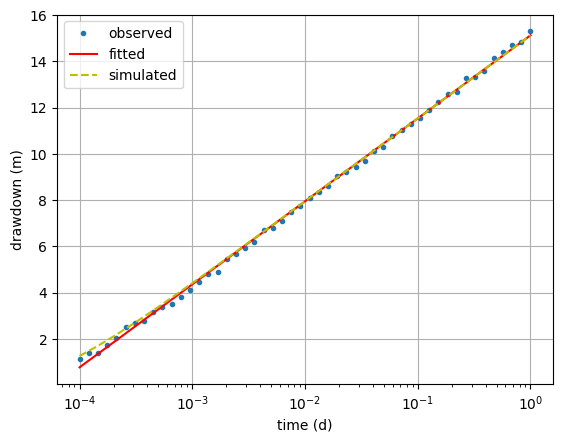

In [46]:
plot_observations(t_obs, s_obs)           # plot observed drawdowns
xline = np.array([[X.min(), X.max()]]).T  # must be 2D matrix!
yline = model.predict(xline)              # predict regression line
plt.semilogx(10**xline, yline, 'r-');     # plot regression line
plt.semilogx(t_obs, s, 'y--');            # plot simulated drawdowns
plt.legend(['observed', 'fitted', 'simulated']);

Because the derived values for T and S are very close to the true values which we used to generate the observations, we get a very good match indeed!

Although the formulas in the Cooper-Jacob method are derived from the Theis solution, it is permissible to apply them to the transient part of the Hantush-Jacob time-drawdown curves. Let's regenerate the Hantush-Jacob dataset, this time including measurement errors.

In [47]:
from maxsypy.special import hantush_jacob

r_obs = 1  # radial distance (m) from the pumping well where the observations are made
t_obs = np.logspace(-4, 5, 100)  # observation times (d)

T = 500   # aquifer transmissivity (m²/d)
S = 0.01  # aquifer storativity (-)
c = 750   # resistance (d) of the bounding aquitard
Q = 1000  # pumping rate (m³/d)

s_obs = hantush_jacob(t=t_obs, r=r_obs, Q=Q, T=T, S=S, c_top=c).squeeze()  # observed drawdown (m)

np.random.seed(0)  # set random seed to ensure we get the same data each time we run the notebook
s_obs += np.random.randn(len(t_obs)) * 0.01  # add error sampled from normal distribution
is_steady = s_obs >= 2  # observed drawdown is steady if it is not less than 2 m

We start with fitting a linear regression model to the transient part of the observed drawdowns:

In [48]:
X = np.log10(t_obs[~is_steady]).reshape(-1, 1) # feature X
y = s_obs[~is_steady]  # target y

model = LinearRegression()  # instantiate class
model.fit(X, y)  # fit data
model.score(X, y)  # R² score

0.9990329264065976

Then we apply the Cooper-Jacob method to derive values for T and S:

In [49]:
T_fitted, S_fitted = cooper_jacob(model)
print(f'Derived T = {T_fitted} m²/d')
print(f'Derived S = {S_fitted}')

Derived T = 516.4818362141544 m²/d
Derived S = 0.008304892660047162


We simulate the drawdowns using these derived values:

In [50]:
s = hantush_jacob(r=r_obs, t=t_obs, Q=Q, T=T_fitted, S=S_fitted, c_top=c).squeeze()

And finally, we visualize the result:

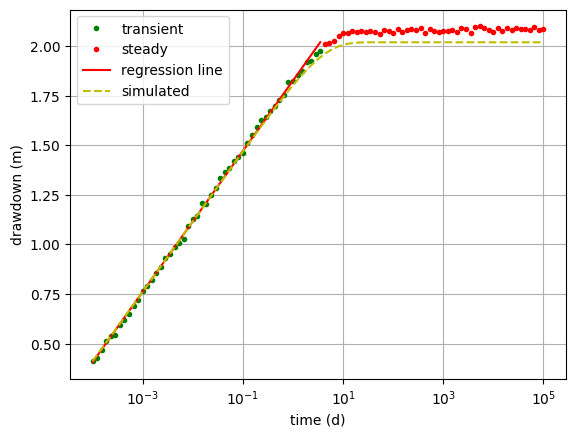

In [51]:
plt.semilogx(t_obs[~is_steady], s_obs[~is_steady], 'g.', label='transient');
plt.semilogx(t_obs[is_steady], s_obs[is_steady], 'r.', label='steady');

xline = np.array([[X.min(), X.max()]]).T
yline = model.predict(xline)
plt.semilogx(10**xline, yline, 'r-', label='regression line');     # plot regression line

plt.semilogx(t_obs, s, 'y--', label='simulated');

plt.legend();
plt.grid();
plt.xlabel('time (d)');
plt.ylabel('drawdown (m)');

The transient part of the drawdown curve is fitted well, but the steady part is not. Fitting the Hantush-Jacob solution to the entire time-drawdown curve using a nonlinear regression algorithm such as Levenberg-Marquardt, is a more reliable way of interpreting these pumping test data. The next session discusses polynomial regression.

### Polynomial Regression

Polynomial regression is an extension of linear regression that models the relationship between the independent variable and the dependent variable as an n-th degree polynomial. This approach allows for capturing more complex patterns in the data, making it useful for datasets where the relationship between variables is nonlinear.

To illustrate the application of polynomial regression, we use function `cooper` to generate hydraulic heads measured in a well where a slug test is performed. Recall that the Cooper et al. model simulates the head change due to a slug test conducted in a well fully penetrating a confined aquifer:

In [52]:
from maxsypy.special import cooper

t_obs = np.logspace(-6, 0, 100)  # observation times (d)

rc = 0.1   # radius (m) of the well-casing
rw = 0.05  # radius (m) of the well-screen
H0 = 2.0   # instantaneous head change (m) in the well
T = 10.0   # aquifer transmissivity (m²/d)
S = 1e-3   # aquifer storativity (-)

h_obs = 10 + cooper(rc=rc, rw=rw, H0=H0, T=T, S=S, t=t_obs)  # observed heads

np.random.seed(2025)  # set random seed
h_obs += np.random.randn(len(t_obs)) * 0.1  # add measurement error

Plot the generated data:

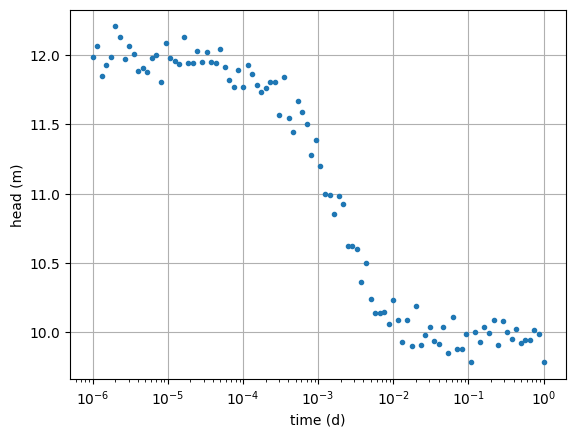

In [53]:
def plot_heads(t_obs, h_obs):

    plt.semilogx(t_obs, h_obs, '.');
    plt.xlabel('time (d)');
    plt.ylabel('head (m)');
    plt.grid();

plot_heads(t_obs, h_obs)

Let's try **polynomial regression** which results in a curve that is not a straight line. The relation between $x$ and $y$ is non-linear in this case, and it is expressed by the following polynomial function:

> $y = b + a_1x + a_2x^2 + ... + a_nx^n = b + \sum_{i=1}^{n}a_ix^i$

where parameters $a_i$ and $b$, also called the **coefficients**, are derived again by minimizing an error function. The highest power $n$ is the **degree** of the polynomial. Note that $n=1$ in case of simple linear regression.

We could use the Scikit-Learn's `PolynomialFeatures` class to preprocess feature `X`, but using NumPy function `polyfit()` is more straightforward. Let's try a polynomial of degree 15:

In [54]:
log_t_obs = np.log10(t_obs)  # log-transform the observation times
coef = np.polyfit(log_t_obs, h_obs, deg=15)

Using function `polyval()` the predictions can be simulated:

In [55]:
from sklearn.metrics import r2_score  # import function to calculate R² score

h_pred = np.polyval(coef, log_t_obs)   # predictions
r2_score(y_true=h_obs, y_pred=h_pred)  # R² score

0.9914484336785312

Now we get a R² score of 0.99, which indicates the polynomial fit is very good! Let's plot the corresponding regression curve:

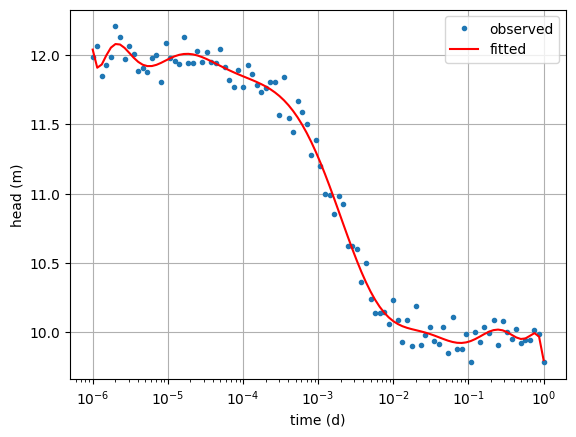

In [56]:
plot_heads(t_obs, h_obs)
plt.semilogx(t_obs, h_pred, 'r-');
plt.legend(['observed', 'fitted']);

The polynomial fit captures the irregularities in the dataset better than a linear regression model would in this case. However, These irregularities can largely be attributed to **noise** in the data, and we do not want the model to take them into account!

### Underfitting and Overfitting

It's clear the linear regression model resulting in a straight line would be too simple to express the relation between the log-transformed observation times and the observed heads. Actually, it is an example of **underfitting**. However, the polynomial model of degree 15 is too specific, and probably, it will not perform well on new data. This is called **overfitting**.

So how can we find the right model that does not suffer from underfitting nor overfitting? How do we obtain a good balance between **optimization**, which fits the data as best as possible during training, and **generalization**, which assures a good model performance on new data during inference?

One best practice in machine learning is to reserve a part of the dataset for **validation** only. That implies a given dataset is split into a training set and a validation set, where the first is used to derive the optimal parameter values, and the latter to evaluate the trained model. In case of overfitting, the model will perform very well on the training data yet poorly on the validation data that are not being used to optimize the parameters.

Let's bring that into practice. First, we import Scikit-Learn function `train_test_split()`:

In [57]:
from sklearn.model_selection import train_test_split

Now we split the dataset into a training and validation set:

In [58]:
X = log_t_obs.reshape(-1, 1)
y = h_obs
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.4,      # 40% is used for validation
                                                  random_state=2024)  # set random seed

So 60% of the data are used to for training and the remaining 40% for validation. The selection of samples happens randomly. For didactic purposes, we've set the random seed; in practice, it is not recommended to do so. Also notice the use of the term *test* instead of *validate*. The difference between validation and testing will be addressed below.

Let's plot the data points used for training (blue) and validation (red) to see if they are randomly selected indeed:

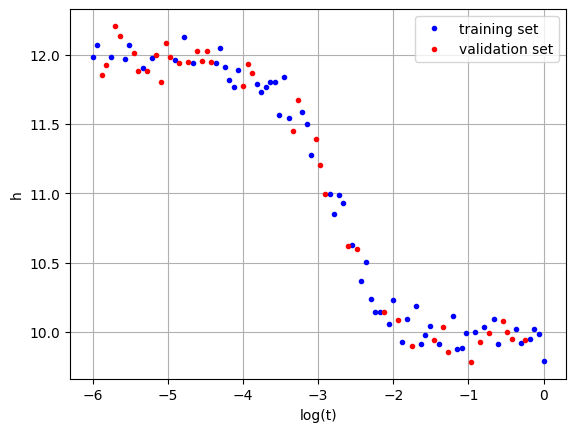

In [59]:
def plot_train_test(X_train, X_val, y_train, y_val, ax=None):
    if ax is None: fig, ax = plt.subplots()
    ax.plot(X_train.flatten(), y_train, 'b.', label='training set');
    ax.plot(X_val.flatten(), y_val, 'r.', label='validation set');
    ax.legend();
    ax.set_xlabel('log(t)');
    ax.set_ylabel('h');
    ax.grid();
    return ax

plot_train_test(X_train, X_val, y_train, y_val);

Looks fine! Let's now illustrate how training and validation data are used by applying polynomial regression, which we've already discussed above:

In [60]:
coef = np.polyfit(X_train.flatten(), y_train, deg=15)  # polynomial fit of degree 15 on training data only!
print(f"training: {r2_score(y_true=y_train, y_pred=np.polyval(coef, X_train.flatten()))}")
print(f"validation: {r2_score(y_true=y_val, y_pred=np.polyval(coef, X_val.flatten()))}")

training: 0.9913899503509417
validation: 0.9887503978612987


So the *fitting is performed on the training data only*, after which the resulting model is evaluated using both the training and validation data! It is seen the model still performs well: R² score is 0.9913 and 0.9888, respectively, for the training and the validation set.

To find the optimal degree of the polynomial fit, we can loop over a range of degrees, say from 1 to 20, while evaluating each model on both the training and validation set. The evaluation **metric** we will use here is the **mean absolute error** (MAE), which is defined in a very similar way as the MSE, except it considers the absolute value of the residuals instead of the square:

> $MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|$

The MAE has the advantage that it is has the same unit as the target.

In [61]:
from sklearn.metrics import mean_absolute_error as MAE  # import MAE function

mae_train = []  # list of MAEs of training data
mae_val = []    # list of MAEs of validation data
coef = []       # list of coefficients
degrees = range(1, 21)  # range of degrees of polynomial function

for degree in degrees:  # loop through degrees

    a = np.polyfit(X_train.flatten(), y_train, degree)  # polynomial fit of training data
    yp_train = np.polyval(a, X_train.flatten())         # predictions of training data
    yp_val = np.polyval(a, X_val.flatten())             # predictions of validation data

    coef.append(a)  # coefficients
    mae_train.append(MAE(y_true=y_train, y_pred=yp_train))  # MAE of training data
    mae_val.append(MAE(y_true=y_val, y_pred=yp_val))        # MAE of validation data

<ipython-input-61-722317e747b8>:10: RankWarning: Polyfit may be poorly conditioned
  a = np.polyfit(X_train.flatten(), y_train, degree)  # polynomial fit of training data
<ipython-input-61-722317e747b8>:10: RankWarning: Polyfit may be poorly conditioned
  a = np.polyfit(X_train.flatten(), y_train, degree)  # polynomial fit of training data


The optimal value for the degree corresponds to the minimum MAE of the validation set:

In [62]:
id_optimal = np.argmin(mae_val)
optimal_degree = degrees[id_optimal]
print(f'Optimal degree is {optimal_degree}')

Optimal degree is 8


Let's plot the result:

Text(12, 0.2, 'Optimal degree')

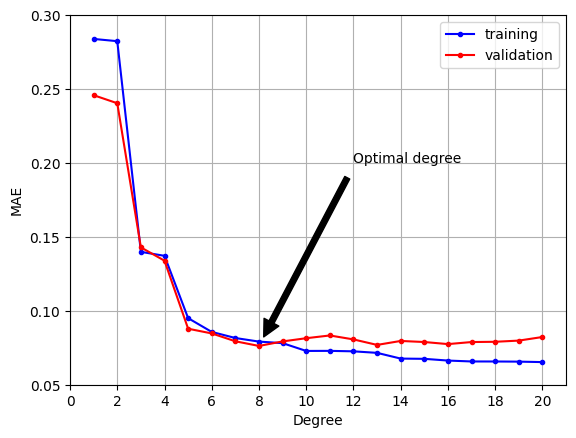

In [63]:
def plot_mae(degrees, mae_train, mae_val, ax=None):
    if ax is None: fig, ax = plt.subplots()
    mae_train_line = ax.plot(degrees, mae_train, 'b.-', label='training')
    mae_val_line = ax.plot(degrees, mae_val, 'r.-', label='validation')
    ax.set_xlabel('Degree')
    ax.set_ylabel('MAE')
    ax.set_xticks(np.arange(0, 22, 2)) # redefine x-ticks
    ax.set_xlim((0, 21))
    ax.set_ylim((0.05, 0.3))
    ax.legend()
    ax.grid()
    return mae_train_line, mae_val_line

plot_mae(degrees, mae_train, mae_val);

# Add an arrow indicating the optimal degree
plt.annotate('Optimal degree', xy=(optimal_degree, mae_val[id_optimal]),
             xytext=(12, 0.2), arrowprops=dict(facecolor='black', shrink=0.05))

The plot illustrates the Mean Absolute Error (MAE) for both training and validation as a function of the polynomial degree. This plot is commonly referred to as the **model complexity graph**. It quantifies the error in relation to the model's complexity, which primarily depends on the number of parameters. In other words, the more parameters, the more complex the model becomes. Here, the number of model parameters corresponds to the polynomial degree plus one. The degree itself is considered a **hyperparameter**, as it is set by the user rather than derived by the machine learning algorithm.

Let's plot the result using a Matplotlib animation:

In [64]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

# initialization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # figure containing 2 axes
ax2.yaxis.set_label_position("right");  # set y-axis of 2nd axes to the right
ax2.yaxis.tick_right();
plot_train_test(X_train, X_val, y_train, y_val, ax=ax1)  # plot training and validation data
xplot = np.linspace(-6, 0, 1000)
regression_line = ax1.plot(xplot, np.polyval(coef[0], xplot),'k-')  # plot regression line
ax1.set_title('degree = 1');
mae_train_line, mae_val_line = plot_mae(degrees[0], mae_train[0], mae_val[0], ax=ax2)

# update function for animation
def update(degree):
    yplot = np.polyval(coef[degree-1], xplot)
    regression_line[0].set_ydata(yplot)
    ax1.set_title('degree = ' + str(degree));
    mae_train_line[0].set_xdata(degrees[:degree])
    mae_train_line[0].set_ydata(mae_train[:degree])
    mae_val_line[0].set_xdata(degrees[:degree])
    mae_val_line[0].set_ydata(mae_val[:degree])

# create animation
ani = FuncAnimation(fig, update, frames=degrees, blit=False, repeat=True)
plt.close()
ani

Upon closer examination of the model complexity graph, we observe that the blue curve (representing training MAE) consistently decreases with increasing degree. However, the red curve (indicating validation MAE) initially decreases but starts rising again beyond degree 8. This behavior suggests that overfitting occurs for degrees higher than 8, implying that the optimal degree for this model indeed is 8! So we finally fit the complete dataset using a polynomial fit of degree 8 and evaluate this final model:

In [65]:
coef = np.polyfit(X.flatten(), y, deg=optimal_degree)
h_pred = np.polyval(coef, X.flatten())
MAE(y_true=y, y_pred=h_pred)

0.07699818709256494

We achieve a mean difference of 0.077 m between the true and predicted heads. Let's plot the resulting regression curve:

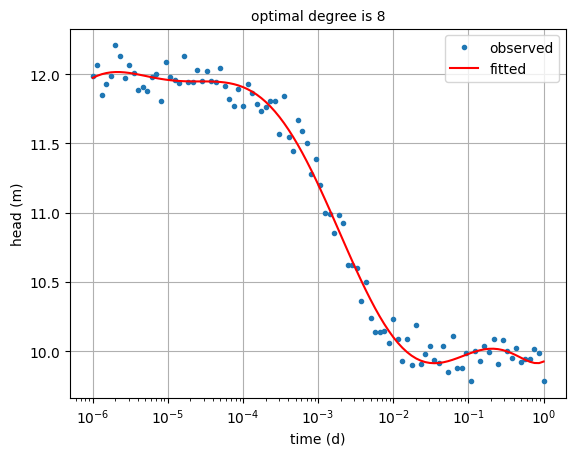

In [66]:
plot_heads(t_obs, h_obs)
plt.semilogx(t_obs, h_pred, 'r-');
plt.title(f'optimal degree is {optimal_degree}', fontdict=dict(fontsize=10));
plt.legend(['observed', 'fitted']);

The red polynomial function of degree 8 would be a better fit than the best fitting straight line obtained from linear regression. On the other hand, it appears to be less affected by irregularities in the data than a high-degree polynomial fit is affected. In conclusion, it captures well the general relationship, although fitting the Cooper et al. solution directly to the time-drawdown curve using a nonlinear regression algorithm such as Levenberg-Marquardt, would be a more reliable way of interpreting these slug test data.

It is common practice to create a third dataset, the **test set**, which is used to evaluate the final model. While some hyperparameters are fine-tuned using the validation set, information may still leak from this set into the model. The test set remains free from any such information leaks, providing an excellent means to evaluate the model's performance on completely new data. Only when this final evaluation using the test set yields positive results can the model be confidently deployed.

### Regularization

Instead of looping over a range of degrees, we may apply a mathematical trick called regularization. In general, **regularization in machine learning** is a set of techniques used to reduce overfitting by penalizing model coefficients. It is beyond the scope of this workshop to delve into the mathematical details.

However, as an example, **LASSO and RIDGE regression** are applied here. The LASSO model performs not so well on this dataset, but the RIDGE model yields a regression curve which is very similar to the polynomial curve of degree 8 derived in previous section. Although we have defined a polynomial of degree 15, the regularization reduced the model's complexity by setting some of the coefficients to zero or values close to zero. The resulting MAE of the RIDGE model equals 0.73, which is slightly better than the 0.77 score of the degree 8 polynomial fit.

In [67]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 15

lasso = make_pipeline(
    PolynomialFeatures(degree, include_bias=False),
    Lasso(alpha=0.5, tol=0.1)
)
lasso.fit(X, y);
print('LASSO:', MAE(y_true=y, y_pred=lasso.predict(X)))

ridge = make_pipeline(
    PolynomialFeatures(degree, include_bias=False),
    Ridge(alpha=0.5, tol=0.1)
)
ridge.fit(X, y);
print('RIDGE:', MAE(y_true=y, y_pred=ridge.predict(X)))

LASSO: 0.1749813282040968
RIDGE: 0.07312344706448717


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.79642e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


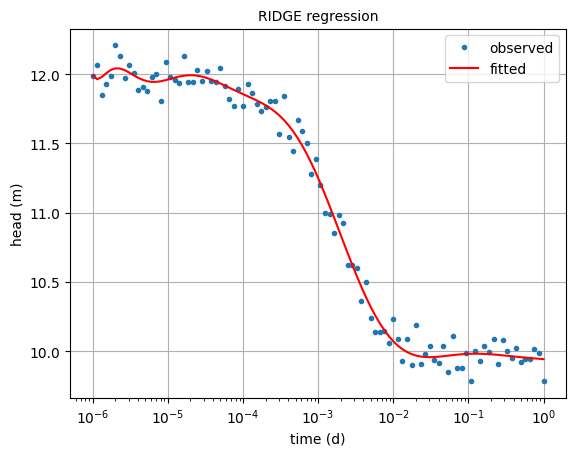

In [68]:
plot_heads(t_obs, h_obs)
xplot = np.linspace(-6, 0, 100).reshape(-1, 1)
plt.plot(10**xplot, ridge.predict(xplot), 'r-');
plt.title('RIDGE regression', fontdict=dict(fontsize=10));
plt.legend(['observed', 'fitted']);

We see that the curve predicted by the RIDGE model corresponds quite well with the fitted eighth-degree polynomial curve!

---